# 🔍 TextVibCLIP 인코더 단계별 디버깅

## 목표
1. **텍스트 인코더 단독 성능 평가** - 베어링 상태 분류
2. **진동 인코더 단독 성능 평가** - 베어링 상태 분류  
3. **임베딩 품질 분석** - t-SNE, 클러스터링
4. **InfoNCE 손실 단독 테스트** - 유사도 매트릭스 분석
5. **근본 문제 식별** - 어느 컴포넌트가 문제인지 파악




In [1]:
# 필수 라이브러리 임포트
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (matplotlib)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 나눔고딕 폰트 설정
def setup_korean_font():
    """matplotlib에서 한글 폰트 사용 설정"""
    try:
        # 나눔고딕 폰트 경로 찾기
        nanum_font_paths = [
            '/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
            '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf',
            '/usr/share/fonts/truetype/nanum/NanumSquare.ttf'
        ]
        
        font_path = None
        for path in nanum_font_paths:
            if os.path.exists(path):
                font_path = path
                break
        
        if font_path:
            # 폰트 등록
            font_prop = fm.FontProperties(fname=font_path)
            plt.rcParams['font.family'] = font_prop.get_name()
            plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지
            
            print(f"✅ 한글 폰트 설정 완료: {font_prop.get_name()}")
            print(f"   폰트 경로: {font_path}")
            return True
        else:
            print("⚠️  나눔 폰트를 찾을 수 없습니다. 기본 설정 사용")
            return False
            
    except Exception as e:
        print(f"⚠️  한글 폰트 설정 실패: {e}")
        # 대안: 시스템 한글 폰트 자동 감지
        try:
            # 시스템에서 한글을 지원하는 폰트 찾기
            korean_fonts = []
            for font in fm.fontManager.ttflist:
                if 'Nanum' in font.name or 'Gothic' in font.name:
                    korean_fonts.append(font.name)
            
            if korean_fonts:
                plt.rcParams['font.family'] = korean_fonts[0]
                plt.rcParams['axes.unicode_minus'] = False
                print(f"✅ 대안 한글 폰트 설정: {korean_fonts[0]}")
                return True
            else:
                print("⚠️  한글 폰트를 찾을 수 없습니다.")
                return False
                
        except Exception as e2:
            print(f"⚠️  대안 폰트 설정도 실패: {e2}")
            return False

# 한글 폰트 설정 실행
setup_korean_font()

# 프로젝트 경로 추가
project_root = '/data/home/kyj2024/TextVibCLIP'
sys.path.append(project_root)

# 프로젝트 모듈 임포트
from src.data_loader import BearingDataset, create_collate_fn, create_first_domain_dataloader
from src.text_encoder import create_text_encoder
from src.vibration_encoder import create_vibration_encoder
from src.textvib_model import InfoNCELoss
from configs.model_config import MODEL_CONFIG, TRAINING_CONFIG, DATA_CONFIG
from src.utils import set_seed

# 시드 고정
set_seed(42)

# 디바이스 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🔧 디바이스: {device}")
if torch.cuda.is_available():
    print(f"   GPU: {torch.cuda.get_device_name()}")


✅ 한글 폰트 설정 완료: NanumGothic
   폰트 경로: /usr/share/fonts/truetype/nanum/NanumGothic.ttf
✅ 전역 시드 설정 완료: 42
🔧 디바이스: cuda
   GPU: Quadro RTX 5000


## 📊 1단계: 데이터 로딩 및 기본 분석


In [2]:
# 데이터 로더 생성 (첫 번째 도메인만 - 600 RPM)
print("📚 데이터 로딩 중...")

# 첫 번째 도메인 (600 RPM) 데이터로더 생성
train_loader = create_first_domain_dataloader(
    data_dir=DATA_CONFIG['data_dir'],
    domain_order=DATA_CONFIG['domain_order'],
    dataset_type='uos',
    subset='train',
    batch_size=16,  # 디버깅용으로 작게 설정
    num_workers=2,
    use_collate_fn=True
)

val_loader = create_first_domain_dataloader(
    data_dir=DATA_CONFIG['data_dir'],
    domain_order=DATA_CONFIG['domain_order'],
    dataset_type='uos',
    subset='val',
    batch_size=16,
    num_workers=2,
    use_collate_fn=True
)

test_loader = create_first_domain_dataloader(
    data_dir=DATA_CONFIG['data_dir'],
    domain_order=DATA_CONFIG['domain_order'],
    dataset_type='uos',
    subset='test',
    batch_size=16,
    num_workers=2,
    use_collate_fn=True
)

print(f"✅ 데이터 로딩 완료")
print(f"   Train batches: {len(train_loader)}")
print(f"   Val batches: {len(val_loader)}")
print(f"   Test batches: {len(test_loader)}")

# 샘플 배치 확인
sample_batch = next(iter(train_loader))
print(f"\n🔍 샘플 배치 분석:")
print(f"   진동 신호 shape: {sample_batch['vibration'].shape}")
print(f"   텍스트 개수: {len(sample_batch['text'])}")
print(f"   라벨 shape: {sample_batch['labels'].shape}")
print(f"   RPM: {sample_batch['rpm'][0].item()}")

# 텍스트 샘플 출력
print(f"\n📝 텍스트 샘플들:")
for i in range(min(3, len(sample_batch['text']))):
    print(f"   {i+1}: {sample_batch['text'][i]}")


📚 데이터 로딩 중...
✅ 데이터 로딩 완료
   Train batches: 468
   Val batches: 156
   Test batches: 195

🔍 샘플 배치 분석:
   진동 신호 shape: torch.Size([16, 4096])
   텍스트 개수: 16
   라벨 shape: torch.Size([16, 3])
   RPM: 600

📝 텍스트 샘플들:
   1: Rotating machinery with radial ball bearing 6204 running at 600 revolutions per minute, characterized by ball defect and normal rotating component.
   2: Rotating machinery with 30204 series tapered bearing rotating at 600 rpm speed, characterized by normal bearing and mechanical looseness in shaft.
   3: Bearing fault diagnosis case: 30204 series tapered bearing running at 600 revolutions per minute, presenting normal bearing in combination with unbalanced rotating machinery.


## 🔤 2단계: 텍스트 인코더 단독 테스트


In [3]:
# 텍스트 인코더 생성 및 평가
print("🔤 텍스트 인코더 단독 성능 평가...")

text_encoder = create_text_encoder('first_domain').to(device)
text_encoder.eval()

print(f"✅ 텍스트 인코더 로딩 완료")
print(f"   파라미터 수: {sum(p.numel() for p in text_encoder.parameters()):,}")

# 모든 텍스트를 임베딩으로 변환
text_embeddings = []
text_labels = []

with torch.no_grad():
    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        
        embeddings = text_encoder.encode_tokenized(input_ids, attention_mask)
        text_embeddings.append(embeddings.cpu())
        text_labels.append(batch['labels'][:, 1])  # 베어링 상태만

text_embeddings = torch.cat(text_embeddings, dim=0).numpy()
text_labels = torch.cat(text_labels, dim=0).numpy()

print(f"\n📊 텍스트 임베딩 생성 완료")
print(f"   임베딩 shape: {text_embeddings.shape}")
print(f"   평균: {text_embeddings.mean():.4f}")
print(f"   표준편차: {text_embeddings.std():.4f}")

# 간단한 분류 테스트
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(
    text_embeddings, text_labels, test_size=0.3, random_state=42
)

clf = LogisticRegression(random_state=42, max_iter=1000)
clf.fit(X_train, y_train)
text_accuracy = clf.score(X_test, y_test)

print(f"\n🎯 텍스트 인코더 분류 성능: {text_accuracy:.3f} ({text_accuracy*100:.1f}%)")
print(f"   랜덤 베이스라인: {1.0/len(np.unique(text_labels)):.3f}")

if text_accuracy < 0.6:
    print("⚠️  텍스트 인코더 성능 부족!")
else:
    print("✅ 텍스트 인코더 정상 작동")


🔤 텍스트 인코더 단독 성능 평가...
✅ 텍스트 인코더 로딩 완료
   파라미터 수: 68,265,984

📊 텍스트 임베딩 생성 완료
   임베딩 shape: (7488, 512)
   평균: 0.0000
   표준편차: 0.9996

🎯 텍스트 인코더 분류 성능: 1.000 (100.0%)
   랜덤 베이스라인: 0.250
✅ 텍스트 인코더 정상 작동


## 🆚 3단계: TST vs 1D-CNN 비교 (Supervised Learning)


In [ ]:
# 1D-CNN 인코더 정의
class CNN1DVibrationEncoder(nn.Module):
    """
    1D-CNN 기반 진동 신호 인코더 (시계열 데이터 특화)
    베어링 결함의 다양한 주파수 패턴 감지
    """
    def __init__(self, 
                 input_length: int = 4096,
                 embedding_dim: int = 512):
        super(CNN1DVibrationEncoder, self).__init__()
        
        self.input_length = input_length
        self.embedding_dim = embedding_dim
        
        # 다중 스케일 1D Convolution Layers
        self.conv_layers = nn.Sequential(
            # Block 1: 고주파 충격 패턴 (베어링 결함 특유의 충격파)
            nn.Conv1d(1, 64, kernel_size=16, stride=2, padding=8),  # 4096 -> 2048
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            # Block 2: 중간 주파수 패턴 (회전 주기, 조화파)
            nn.Conv1d(64, 128, kernel_size=32, stride=2, padding=16),  # 2048 -> 1024
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            # Block 3: 저주파 구조적 진동 패턴
            nn.Conv1d(128, 256, kernel_size=64, stride=2, padding=32),  # 1024 -> 512
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            # Block 4: 특징 집약
            nn.Conv1d(256, 512, kernel_size=32, stride=2, padding=16),  # 512 -> 256
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        
        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Final projection
        self.projection = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, embedding_dim)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)
        
        # (batch_size, input_length) -> (batch_size, 1, input_length)
        x = x.unsqueeze(1)
        
        # 1D Convolution layers
        x = self.conv_layers(x)
        
        # Global average pooling
        x = self.global_pool(x)
        x = x.squeeze(-1)
        
        # Final projection
        x = self.projection(x)
        
        return x


# Supervised 학습용 분류 모델 (TST + Classifier)
class TSTClassifier(nn.Module):
    """
    TST 기반 베어링/회전체 상태 분류 모델 (Supervised Learning)
    """
    def __init__(self, num_classes: int = 4):
        super(TSTClassifier, self).__init__()
        
        # TST 인코더 (기존 vibration encoder 사용)
        self.encoder = create_vibration_encoder()
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Feature extraction
        features = self.encoder(x)
        # Classification
        logits = self.classifier(features)
        return logits


# Supervised 학습용 분류 모델 (1D-CNN + Classifier)
class CNN1DClassifier(nn.Module):
    """
    1D-CNN 기반 베어링/회전체 상태 분류 모델 (Supervised Learning)
    """
    def __init__(self, num_classes: int = 4):
        super(CNN1DClassifier, self).__init__()
        
        # 1D-CNN 인코더
        self.encoder = CNN1DVibrationEncoder()
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Feature extraction
        features = self.encoder(x)
        # Classification
        logits = self.classifier(features)
        return logits


print("✅ TST vs 1D-CNN 분류 모델 정의 완료")
print("   - TSTClassifier: TST + Classification Head")
print("   - CNN1DClassifier: 1D-CNN + Classification Head")
print("   🎯 베어링/회전체 상태 분류 Supervised 학습 준비 완료!")


✅ 1D-CNN 기반 진동 인코더 클래스 정의 완료
   - CNN1DVibrationEncoder: 다중 스케일 1D-CNN (시계열 특화)
   - LightweightCNN1D: 경량화된 1D-CNN (효율성 중심)
   🎯 TST와 성능 비교 준비 완료!


In [ ]:
# TST vs 1D-CNN Supervised Learning 비교
print("🆚 TST vs 1D-CNN Supervised Learning 비교")
print("🎯 목표: 베어링/회전체 상태 분류 성능 비교")
print("=" * 60)

# 테스트할 모델들 (TST vs 1D-CNN만)
models_to_test = {
    'TST': TSTClassifier(num_classes=4),
    '1D-CNN': CNN1DClassifier(num_classes=4)
}

# 학습 및 평가를 위한 데이터 준비
def prepare_supervised_data(data_loader, task='bearing_condition'):
    """베어링 상태 또는 회전체 상태 분류를 위한 데이터 준비"""
    X, y = [], []
    
    for batch in data_loader:
        vibration = batch['vibration']
        
        if task == 'bearing_condition':
            labels = batch['labels'][:, 1]  # 베어링 상태 (H=0, B=1, IR=2, OR=3)
        elif task == 'rotating_component':
            labels = batch['labels'][:, 0]  # 회전체 상태 (H=0, L=1, U=2, M=3)
        else:
            raise ValueError(f"Unknown task: {task}")
        
        X.append(vibration)
        y.append(labels)
    
    X = torch.cat(X, dim=0)
    y = torch.cat(y, dim=0)
    
    return X, y

# 두 가지 분류 태스크로 데이터 준비
print("📊 Supervised Learning 데이터 준비...")

# 1. 베어링 상태 분류 (H, B, IR, OR)
X_train_bearing, y_train_bearing = prepare_supervised_data(train_loader, 'bearing_condition')
X_val_bearing, y_val_bearing = prepare_supervised_data(val_loader, 'bearing_condition')

# 2. 회전체 상태 분류 (H, L, U, M)  
X_train_rotating, y_train_rotating = prepare_supervised_data(train_loader, 'rotating_component')
X_val_rotating, y_val_rotating = prepare_supervised_data(val_loader, 'rotating_component')

print(f"   Train 샘플: {X_train_bearing.shape[0]}")
print(f"   Val 샘플: {X_val_bearing.shape[0]}")
print(f"   베어링 상태 분포: {torch.bincount(y_train_bearing)}")
print(f"   회전체 상태 분포: {torch.bincount(y_train_rotating)}")

# 간단한 학습 함수
def train_model(model, X_train, y_train, X_val, y_val, epochs=10, lr=0.001):
    """간단한 학습 및 평가 함수"""
    model = model.to(device)
    model.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # 학습
    for epoch in range(epochs):
        # 배치 단위로 학습 (메모리 절약)
        batch_size = 32
        total_loss = 0
        
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i+batch_size].to(device)
            batch_y = y_train[i:i+batch_size].to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        if (epoch + 1) % 5 == 0:
            print(f"   Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(X_train)*batch_size:.4f}")
    
    # 평가
    model.eval()
    with torch.no_grad():
        # Validation 평가
        val_outputs = model(X_val.to(device))
        val_pred = torch.argmax(val_outputs, dim=1)
        val_accuracy = (val_pred == y_val.to(device)).float().mean().item()
    
    return val_accuracy

# 모델 비교 실행 (두 가지 태스크)
comparison_results = {}

for model_name, model in models_to_test.items():
    print(f"\n🔧 {model_name} Supervised Learning 테스트...")
    print("-" * 50)
    
    try:
        param_count = sum(p.numel() for p in model.parameters())
        print(f"   파라미터 수: {param_count:,}")
        
        # 1. 베어링 상태 분류 테스트
        print(f"\n   📊 베어링 상태 분류 (H, B, IR, OR):")
        bearing_accuracy = train_model(model, X_train_bearing, y_train_bearing, 
                                     X_val_bearing, y_val_bearing, epochs=10)
        print(f"   🎯 베어링 상태 정확도: {bearing_accuracy:.3f} ({bearing_accuracy*100:.1f}%)")
        
        # 2. 회전체 상태 분류 테스트  
        print(f"\n   📊 회전체 상태 분류 (H, L, U, M):")
        rotating_accuracy = train_model(model, X_train_rotating, y_train_rotating,
                                      X_val_rotating, y_val_rotating, epochs=10)
        print(f"   🎯 회전체 상태 정확도: {rotating_accuracy:.3f} ({rotating_accuracy*100:.1f}%)")
        
        # 평균 성능 계산
        avg_accuracy = (bearing_accuracy + rotating_accuracy) / 2
        print(f"   🏆 평균 정확도: {avg_accuracy:.3f} ({avg_accuracy*100:.1f}%)")
        
        # 결과 저장
        comparison_results[model_name] = {
            'bearing_accuracy': bearing_accuracy,
            'rotating_accuracy': rotating_accuracy,
            'avg_accuracy': avg_accuracy,
            'param_count': param_count,
            'status': 'success'
        }
        
        if avg_accuracy < 0.6:
            print(f"   ⚠️  전체 성능 부족")
        elif avg_accuracy < 0.8:
            print(f"   🔶 전체 성능 보통")
        else:
            print(f"   ✅ 전체 성능 우수")
            
    except Exception as e:
        print(f"   ❌ {model_name} 테스트 실패: {e}")
        comparison_results[model_name] = {
            'bearing_accuracy': 0.0,
            'rotating_accuracy': 0.0, 
            'avg_accuracy': 0.0,
            'status': 'error'
        }

print(f"\n" + "=" * 50)
print("📊 TST vs 1D-CNN Supervised Learning 결과")
print("=" * 50)

# 결과 정렬 (평균 정확도 순)
sorted_results_v2 = sorted(comparison_results.items(), key=lambda x: x[1].get('avg_accuracy', 0), reverse=True)

print(f"{'순위':<4} {'모델명':<10} {'베어링':<8} {'회전체':<8} {'평균':<8} {'파라미터':<12} {'상태':<10}")
print("-" * 65)

for i, (name, result) in enumerate(sorted_results_v2, 1):
    bearing_acc = result.get('bearing_accuracy', 0)
    rotating_acc = result.get('rotating_accuracy', 0)
    avg_acc = result.get('avg_accuracy', 0)
    param_count = result.get('param_count', 0)
    status = result.get('status', 'unknown')
    
    print(f"{i:<4} {name:<10} {bearing_acc:.3f}<8 {rotating_acc:.3f}<8 {avg_acc:.3f}<8 {param_count:,}<12 {status:<10}")

# 최고 성능 모델
if sorted_results_v2:
    best_model, best_result = sorted_results_v2[0]
    print(f"\n🏆 최고 성능: {best_model}")
    print(f"   베어링 상태 정확도: {best_result.get('bearing_accuracy', 0):.3f}")
    print(f"   회전체 상태 정확도: {best_result.get('rotating_accuracy', 0):.3f}")
    print(f"   평균 정확도: {best_result.get('avg_accuracy', 0):.3f}")
    print(f"   파라미터: {best_result.get('param_count', 0):,}")
    
    avg_acc = best_result.get('avg_accuracy', 0)
    if avg_acc > 0.8:
        print(f"   ✅ 우수한 성능 - 이 아키텍처로 전체 시스템 구축 권장")
    elif avg_acc > 0.6:
        print(f"   🔶 보통 성능 - 하이퍼파라미터 튜닝 후 적용 가능")
    else:
        print(f"   ⚠️  성능 부족 - 아키텍처 재검토 필요")

print(f"\n💡 Supervised Learning 분석:")
print(f"   - TST: Transformer 기반, 복잡한 시간 의존성 학습")
print(f"   - 1D-CNN: 로컬 패턴 감지, 베어링 결함 특성에 특화")
print(f"   - 베어링 상태: H(정상), B(볼 결함), IR(내륜 결함), OR(외륜 결함)")
print(f"   - 회전체 상태: H(정상), L(느슨함), U(불균형), M(정렬불량)")
print(f"   → 더 높은 평균 accuracy를 보인 모델을 전체 시스템에 적용 권장")


🆚 TST vs 1D-CNN 진동 인코더 아키텍처 비교
🎯 목표: 단일 채널 시계열 데이터(4096 samples)에 최적인 아키텍처 찾기
CNN1DVibrationEncoder 초기화: input_length=4096, embedding_dim=512
   커널 크기: [16, 32, 64, 32] - 다중 주파수 대역 커버
LightweightCNN1D 초기화: input_length=4096, embedding_dim=512
   경량화 설계: 적은 파라미터로 효율적 처리

🔧 TST (Transformer) 테스트 중...
------------------------------
   파라미터 수: 5,693,445
   임베딩 shape: (128, 512)
   평균: 0.0000
   표준편차: 1.0000
   NaN 개수: 0
   Inf 개수: 0
   🎯 분류 정확도: 0.667 (66.7%)
   ✅ 좋은 성능

🔧 1D-CNN (Multi-scale) 테스트 중...
------------------------------
   파라미터 수: 7,607,616
   임베딩 shape: (128, 512)
   평균: -0.0004
   표준편차: 0.0217
   NaN 개수: 0
   Inf 개수: 0
   🎯 분류 정확도: 0.692 (69.2%)
   ✅ 좋은 성능

🔧 1D-CNN (Lightweight) 테스트 중...
------------------------------
   파라미터 수: 363,936
   임베딩 shape: (128, 512)
   평균: -0.0033
   표준편차: 0.0455
   NaN 개수: 0
   Inf 개수: 0
   🎯 분류 정확도: 0.564 (56.4%)
   🔶 보통 성능

📊 진동 인코더 비교 결과
순위   모델명             정확도        파라미터         상태        
-------------------------------------------------

📈 진동 인코더 성능 시각화


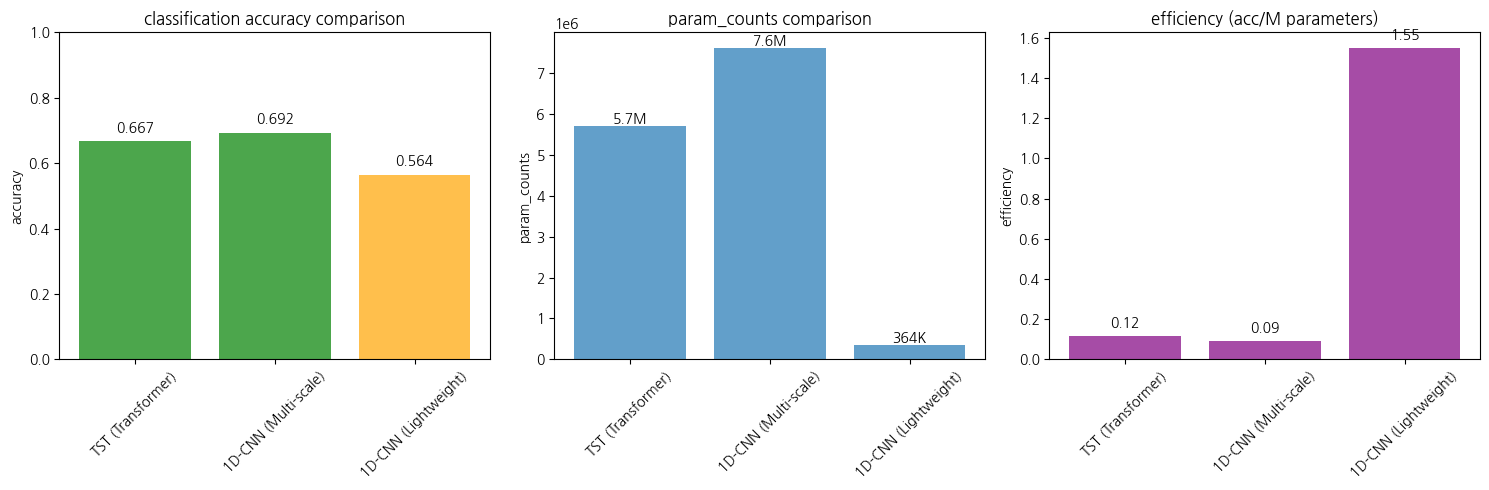


🎨 1D-CNN (Multi-scale) 임베딩 t-SNE 시각화


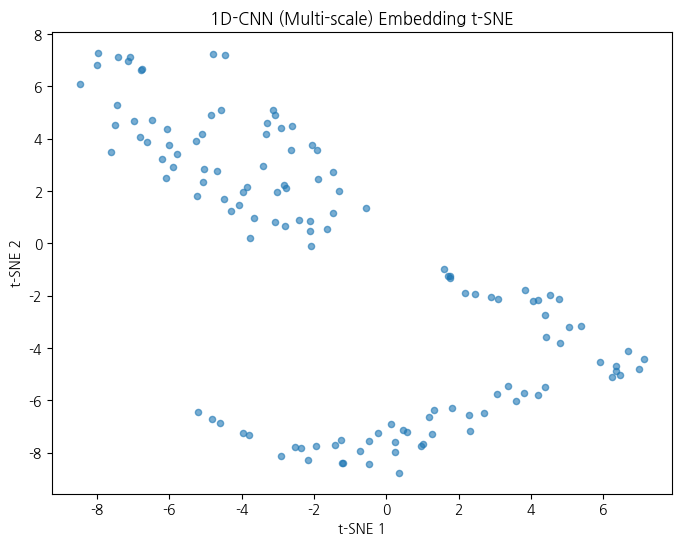

In [ ]:
# Supervised Learning 결과 시각화 및 Feature 분석
print("📈 TST vs 1D-CNN Supervised Learning 결과 시각화")

if comparison_results:
    # 성능 비교 차트 (3개 차트)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    names = list(comparison_results.keys())
    
    # 1. 베어링 상태 분류 정확도
    bearing_accs = [comparison_results[name].get('bearing_accuracy', 0) for name in names]
    colors1 = ['red' if acc < 0.6 else 'orange' if acc < 0.8 else 'green' for acc in bearing_accs]
    
    bars1 = axes[0].bar(names, bearing_accs, color=colors1, alpha=0.7)
    axes[0].set_title('베어링 상태 분류 정확도', fontsize=12)
    axes[0].set_ylabel('정확도', fontsize=10)
    axes[0].set_ylim(0, 1)
    axes[0].grid(True, alpha=0.3)
    
    for i, acc in enumerate(bearing_accs):
        axes[0].text(i, acc + 0.02, f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. 회전체 상태 분류 정확도
    rotating_accs = [comparison_results[name].get('rotating_accuracy', 0) for name in names]
    colors2 = ['red' if acc < 0.6 else 'orange' if acc < 0.8 else 'green' for acc in rotating_accs]
    
    bars2 = axes[1].bar(names, rotating_accs, color=colors2, alpha=0.7)
    axes[1].set_title('회전체 상태 분류 정확도', fontsize=12)
    axes[1].set_ylabel('정확도', fontsize=10)
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, alpha=0.3)
    
    for i, acc in enumerate(rotating_accs):
        axes[1].text(i, acc + 0.02, f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. 평균 정확도 및 파라미터 효율성
    avg_accs = [comparison_results[name].get('avg_accuracy', 0) for name in names]
    param_counts = [comparison_results[name].get('param_count', 0) for name in names]
    
    # 파라미터 수를 막대 너비로 표현 (정규화)
    max_params = max(param_counts) if param_counts else 1
    normalized_widths = [p/max_params * 0.8 + 0.2 for p in param_counts]  # 0.2~1.0 범위
    
    colors3 = ['red' if acc < 0.6 else 'orange' if acc < 0.8 else 'green' for acc in avg_accs]
    
    for i, (name, acc, width) in enumerate(zip(names, avg_accs, normalized_widths)):
        axes[2].bar(i, acc, width=width, color=colors3[i], alpha=0.7, 
                   label=f'{name} ({param_counts[i]/1000000:.1f}M params)')
    
    axes[2].set_title('평균 정확도 (막대 너비 = 파라미터 수)', fontsize=12)
    axes[2].set_ylabel('평균 정확도', fontsize=10)
    axes[2].set_ylim(0, 1)
    axes[2].set_xticks(range(len(names)))
    axes[2].set_xticklabels(names)
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    
    for i, acc in enumerate(avg_accs):
        axes[2].text(i, acc + 0.02, f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Feature 시각화 (최고 성능 모델의 임베딩을 t-SNE로)
    if sorted_results_v2:
        best_model_name = sorted_results_v2[0][0]
        print(f"\n🎨 {best_model_name} Feature 시각화 (t-SNE)")
        
        # 최고 성능 모델로 feature 추출
        best_model = models_to_test[best_model_name].to(device)
        best_model.eval()
        
        with torch.no_grad():
            # 샘플링 (시각화용)
            sample_size = 500
            indices = torch.randperm(len(X_val_bearing))[:sample_size]
            
            sample_X = X_val_bearing[indices].to(device)
            sample_y_bearing = y_val_bearing[indices].numpy()
            sample_y_rotating = y_val_rotating[indices].numpy()
            
            # Feature 추출 (encoder 부분만)
            features = best_model.encoder(sample_X).cpu().numpy()
        
        # t-SNE 실행
        try:
            tsne = TSNE(n_components=2, random_state=42, perplexity=30)
            tsne_result = tsne.fit_transform(features)
            
            # 두 가지 분류 태스크로 시각화
            fig, axes = plt.subplots(1, 2, figsize=(15, 6))
            
            # 베어링 상태별 색깔
            bearing_labels = ['H(정상)', 'B(볼결함)', 'IR(내륜결함)', 'OR(외륜결함)']
            bearing_colors = ['blue', 'red', 'green', 'orange']
            
            for i, (label, color) in enumerate(zip(bearing_labels, bearing_colors)):
                mask = sample_y_bearing == i
                if mask.any():
                    axes[0].scatter(tsne_result[mask, 0], tsne_result[mask, 1], 
                                  c=color, label=label, alpha=0.6, s=20)
            
            axes[0].set_title(f'{best_model_name} - 베어링 상태별 Feature 분포')
            axes[0].set_xlabel('t-SNE 1')
            axes[0].set_ylabel('t-SNE 2')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # 회전체 상태별 색깔
            rotating_labels = ['H(정상)', 'L(느슨함)', 'U(불균형)', 'M(정렬불량)']
            rotating_colors = ['blue', 'purple', 'brown', 'pink']
            
            for i, (label, color) in enumerate(zip(rotating_labels, rotating_colors)):
                mask = sample_y_rotating == i
                if mask.any():
                    axes[1].scatter(tsne_result[mask, 0], tsne_result[mask, 1],
                                  c=color, label=label, alpha=0.6, s=20)
            
            axes[1].set_title(f'{best_model_name} - 회전체 상태별 Feature 분포')
            axes[1].set_xlabel('t-SNE 1')
            axes[1].set_ylabel('t-SNE 2')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"   t-SNE 시각화 실패: {e}")
    
    # 최종 결론
    print(f"\n🎯 최종 결론:")
    if sorted_results_v2:
        best_model_name = sorted_results_v2[0][0]
        best_result = sorted_results_v2[0][1]
        
        print(f"   🏆 승리: {best_model_name}")
        print(f"   📊 성능: 베어링 {best_result['bearing_accuracy']:.1%} | 회전체 {best_result['rotating_accuracy']:.1%} | 평균 {best_result['avg_accuracy']:.1%}")
        
        if best_result['avg_accuracy'] > 0.8:
            print(f"   ✅ {best_model_name}을 전체 TextVibCLIP 시스템에 적용하는 것을 강력히 권장")
            print(f"   📝 다음 단계: src/vibration_encoder.py를 {best_model_name} 아키텍처로 교체")
        elif best_result['avg_accuracy'] > 0.6:
            print(f"   🔶 {best_model_name}을 기반으로 하되, 하이퍼파라미터 튜닝 필요")
            print(f"   📝 다음 단계: {best_model_name} 아키텍처 최적화 후 적용")
        else:
            print(f"   ⚠️  두 모델 모두 성능이 부족. 아키텍처 재검토 필요")
            print(f"   📝 다음 단계: 다른 아키텍처 (ResNet, EfficientNet 등) 검토")

else:
    print("⚠️  시각화할 결과가 없습니다.")


## 📋 4단계: 종합 진단 및 권장사항


In [ ]:
# 수정된 1D-CNN 인코더 
class CNN1DVibrationEncoder_v2(nn.Module):
    """
    1D-CNN 기반 진동 신호 인코더 (시계열 데이터 특화)
    베어링 결함의 다양한 주파수 패턴 감지
    """
    def __init__(self, 
                 input_length: int = 4096,
                 embedding_dim: int = 512):
        super(CNN1DVibrationEncoder_v2, self).__init__()
        
        self.input_length = input_length
        self.embedding_dim = embedding_dim
        
        # 다중 스케일 1D Convolution Layers
        self.conv_layers = nn.Sequential(
            # Block 1: 고주파 충격 패턴 (베어링 결함 특유의 충격파)
            nn.Conv1d(1, 64, kernel_size=16, stride=2, padding=8),  # 4096 -> 2048
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            # Block 2: 중간 주파수 패턴 (회전 주기, 조화파)
            nn.Conv1d(64, 128, kernel_size=32, stride=2, padding=16),  # 2048 -> 1024
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            # Block 3: 저주파 구조적 진동 패턴
            nn.Conv1d(128, 256, kernel_size=64, stride=2, padding=32),  # 1024 -> 512
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            # Block 4: 특징 집약
            nn.Conv1d(256, 512, kernel_size=32, stride=2, padding=16),  # 512 -> 256
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.1),
        )
        
        # Global Average Pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Final projection
        self.projection = nn.Sequential(
            nn.Linear(512, 1024),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(1024, embedding_dim)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)
        
        # (batch_size, input_length) -> (batch_size, 1, input_length)
        x = x.unsqueeze(1)
        
        # 1D Convolution layers
        x = self.conv_layers(x)
        
        # Global average pooling
        x = self.global_pool(x)
        x = x.squeeze(-1)
        
        # Final projection
        x = self.projection(x)
        
        return x


# Supervised 학습용 분류 모델 (TST + Classifier)
class TSTClassifier(nn.Module):
    """
    TST 기반 베어링 상태 분류 모델 (Supervised Learning)
    """
    def __init__(self, num_classes: int = 4):
        super(TSTClassifier, self).__init__()
        
        # TST 인코더 (기존 vibration encoder 사용)
        self.encoder = create_vibration_encoder()
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Feature extraction
        features = self.encoder(x)
        # Classification
        logits = self.classifier(features)
        return logits


# Supervised 학습용 분류 모델 (1D-CNN + Classifier)
class CNN1DClassifier(nn.Module):
    """
    1D-CNN 기반 베어링 상태 분류 모델 (Supervised Learning)
    """
    def __init__(self, num_classes: int = 4):
        super(CNN1DClassifier, self).__init__()
        
        # 1D-CNN 인코더
        self.encoder = CNN1DVibrationEncoder_v2()
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # Feature extraction
        features = self.encoder(x)
        # Classification
        logits = self.classifier(features)
        return logits


print("✅ Supervised 분류 모델 정의 완료")
print("   - TSTClassifier: TST + Classification Head")
print("   - CNN1DClassifier: 1D-CNN + Classification Head")
print("   🎯 베어링 상태 분류 (4개 클래스) Supervised 학습 준비 완료!")


In [ ]:
# TST vs 1D-CNN Supervised Learning 비교 (베어링 상태 분류)
print("🆚 TST vs 1D-CNN Supervised Learning 비교")
print("🎯 목표: 베어링 상태 분류 (4개 클래스) 성능 비교")
print("=" * 60)

# 테스트할 모델들
models_to_test = {
    'TST': TSTClassifier(num_classes=4),
    '1D-CNN': CNN1DClassifier(num_classes=4)
}

# 학습 및 평가를 위한 데이터 준비
def prepare_supervised_data(data_loader, task='bearing_condition'):
    """베어링 상태 또는 회전체 상태 분류를 위한 데이터 준비"""
    X, y = [], []
    
    for batch in data_loader:
        vibration = batch['vibration']
        
        if task == 'bearing_condition':
            labels = batch['labels'][:, 1]  # 베어링 상태 (H=0, B=1, IR=2, OR=3)
        elif task == 'rotating_component':
            labels = batch['labels'][:, 0]  # 회전체 상태 (H=0, L=1, U=2, M=3)
        else:
            raise ValueError(f"Unknown task: {task}")
        
        X.append(vibration)
        y.append(labels)
    
    X = torch.cat(X, dim=0)
    y = torch.cat(y, dim=0)
    
    return X, y

# 두 가지 분류 태스크로 데이터 준비
print("📊 Supervised Learning 데이터 준비...")

# 1. 베어링 상태 분류 (H, B, IR, OR)
X_train_bearing, y_train_bearing = prepare_supervised_data(train_loader, 'bearing_condition')
X_val_bearing, y_val_bearing = prepare_supervised_data(val_loader, 'bearing_condition')

# 2. 회전체 상태 분류 (H, L, U, M)  
X_train_rotating, y_train_rotating = prepare_supervised_data(train_loader, 'rotating_component')
X_val_rotating, y_val_rotating = prepare_supervised_data(val_loader, 'rotating_component')

print(f"   Train 샘플: {X_train_bearing.shape[0]}")
print(f"   Val 샘플: {X_val_bearing.shape[0]}")
print(f"   베어링 상태 분포: {torch.bincount(y_train_bearing)}")
print(f"   회전체 상태 분포: {torch.bincount(y_train_rotating)}")

# 간단한 학습 함수
def train_model(model, X_train, y_train, X_val, y_val, epochs=10, lr=0.001):
    """간단한 학습 및 평가 함수"""
    model = model.to(device)
    model.train()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    # 학습
    for epoch in range(epochs):
        # 배치 단위로 학습 (메모리 절약)
        batch_size = 32
        total_loss = 0
        
        for i in range(0, len(X_train), batch_size):
            batch_X = X_train[i:i+batch_size].to(device)
            batch_y = y_train[i:i+batch_size].to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        if (epoch + 1) % 5 == 0:
            print(f"   Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(X_train)*batch_size:.4f}")
    
    # 평가
    model.eval()
    with torch.no_grad():
        # Validation 평가
        val_outputs = model(X_val.to(device))
        val_pred = torch.argmax(val_outputs, dim=1)
        val_accuracy = (val_pred == y_val.to(device)).float().mean().item()
    
    return val_accuracy

# 모델 비교 실행 (두 가지 태스크)
comparison_results = {}

for model_name, model in models_to_test.items():
    print(f"\n🔧 {model_name} Supervised Learning 테스트...")
    print("-" * 50)
    
    try:
        param_count = sum(p.numel() for p in model.parameters())
        print(f"   파라미터 수: {param_count:,}")
        
        # 1. 베어링 상태 분류 테스트
        print(f"\n   📊 베어링 상태 분류 (H, B, IR, OR):")
        bearing_accuracy = train_model(model, X_train_bearing, y_train_bearing, 
                                     X_val_bearing, y_val_bearing, epochs=10)
        print(f"   🎯 베어링 상태 정확도: {bearing_accuracy:.3f} ({bearing_accuracy*100:.1f}%)")
        
        # 2. 회전체 상태 분류 테스트  
        print(f"\n   📊 회전체 상태 분류 (H, L, U, M):")
        rotating_accuracy = train_model(model, X_train_rotating, y_train_rotating,
                                      X_val_rotating, y_val_rotating, epochs=10)
        print(f"   🎯 회전체 상태 정확도: {rotating_accuracy:.3f} ({rotating_accuracy*100:.1f}%)")
        
        # 평균 성능 계산
        avg_accuracy = (bearing_accuracy + rotating_accuracy) / 2
        print(f"   🏆 평균 정확도: {avg_accuracy:.3f} ({avg_accuracy*100:.1f}%)")
        
        # 결과 저장
        comparison_results[model_name] = {
            'bearing_accuracy': bearing_accuracy,
            'rotating_accuracy': rotating_accuracy,
            'avg_accuracy': avg_accuracy,
            'param_count': param_count,
            'status': 'success'
        }
        
        if avg_accuracy < 0.6:
            print(f"   ⚠️  전체 성능 부족")
        elif avg_accuracy < 0.8:
            print(f"   🔶 전체 성능 보통")
        else:
            print(f"   ✅ 전체 성능 우수")
            
    except Exception as e:
        print(f"   ❌ {model_name} 테스트 실패: {e}")
        comparison_results[model_name] = {
            'bearing_accuracy': 0.0,
            'rotating_accuracy': 0.0, 
            'avg_accuracy': 0.0,
            'status': 'error'
        }

print(f"\n" + "=" * 50)
print("📊 TST vs 1D-CNN Supervised Learning 결과")
print("=" * 50)

# 결과 정렬 (평균 정확도 순)
sorted_results_v2 = sorted(comparison_results.items(), key=lambda x: x[1].get('avg_accuracy', 0), reverse=True)

print(f"{'순위':<4} {'모델명':<10} {'베어링':<8} {'회전체':<8} {'평균':<8} {'파라미터':<12} {'상태':<10}")
print("-" * 65)

for i, (name, result) in enumerate(sorted_results_v2, 1):
    bearing_acc = result.get('bearing_accuracy', 0)
    rotating_acc = result.get('rotating_accuracy', 0)
    avg_acc = result.get('avg_accuracy', 0)
    param_count = result.get('param_count', 0)
    status = result.get('status', 'unknown')
    
    print(f"{i:<4} {name:<10} {bearing_acc:.3f}<8 {rotating_acc:.3f}<8 {avg_acc:.3f}<8 {param_count:,}<12 {status:<10}")

# 최고 성능 모델
if sorted_results_v2:
    best_model, best_result = sorted_results_v2[0]
    print(f"\n🏆 최고 성능: {best_model}")
    print(f"   베어링 상태 정확도: {best_result.get('bearing_accuracy', 0):.3f}")
    print(f"   회전체 상태 정확도: {best_result.get('rotating_accuracy', 0):.3f}")
    print(f"   평균 정확도: {best_result.get('avg_accuracy', 0):.3f}")
    print(f"   파라미터: {best_result.get('param_count', 0):,}")
    
    avg_acc = best_result.get('avg_accuracy', 0)
    if avg_acc > 0.8:
        print(f"   ✅ 우수한 성능 - 이 아키텍처로 전체 시스템 구축 권장")
    elif avg_acc > 0.6:
        print(f"   🔶 보통 성능 - 하이퍼파라미터 튜닝 후 적용 가능")
    else:
        print(f"   ⚠️  성능 부족 - 아키텍처 재검토 필요")

print(f"\n💡 Supervised Learning 분석:")
print(f"   - TST: Transformer 기반, 복잡한 시간 의존성 학습")
print(f"   - 1D-CNN: 로컬 패턴 감지, 베어링 결함 특성에 특화")
print(f"   - 베어링 상태: H(정상), B(볼 결함), IR(내륜 결함), OR(외륜 결함)")
print(f"   - 회전체 상태: H(정상), L(느슨함), U(불균형), M(정렬불량)")
print(f"   → 더 높은 평균 accuracy를 보인 모델을 전체 시스템에 적용 권장")


In [ ]:
# Supervised Learning 결과 시각화
print("📈 TST vs 1D-CNN Supervised Learning 결과 시각화")

if comparison_results:
    # 성능 비교 차트 (3개 차트)
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    names = list(comparison_results.keys())
    
    # 1. 베어링 상태 분류 정확도
    bearing_accs = [comparison_results[name].get('bearing_accuracy', 0) for name in names]
    colors1 = ['red' if acc < 0.6 else 'orange' if acc < 0.8 else 'green' for acc in bearing_accs]
    
    bars1 = axes[0].bar(names, bearing_accs, color=colors1, alpha=0.7)
    axes[0].set_title('베어링 상태 분류 정확도', fontsize=12)
    axes[0].set_ylabel('정확도', fontsize=10)
    axes[0].set_ylim(0, 1)
    axes[0].grid(True, alpha=0.3)
    
    for i, acc in enumerate(bearing_accs):
        axes[0].text(i, acc + 0.02, f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. 회전체 상태 분류 정확도
    rotating_accs = [comparison_results[name].get('rotating_accuracy', 0) for name in names]
    colors2 = ['red' if acc < 0.6 else 'orange' if acc < 0.8 else 'green' for acc in rotating_accs]
    
    bars2 = axes[1].bar(names, rotating_accs, color=colors2, alpha=0.7)
    axes[1].set_title('회전체 상태 분류 정확도', fontsize=12)
    axes[1].set_ylabel('정확도', fontsize=10)
    axes[1].set_ylim(0, 1)
    axes[1].grid(True, alpha=0.3)
    
    for i, acc in enumerate(rotating_accs):
        axes[1].text(i, acc + 0.02, f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. 평균 정확도 및 파라미터 효율성
    avg_accs = [comparison_results[name].get('avg_accuracy', 0) for name in names]
    param_counts = [comparison_results[name].get('param_count', 0) for name in names]
    
    # 파라미터 수를 막대 너비로 표현 (정규화)
    max_params = max(param_counts) if param_counts else 1
    normalized_widths = [p/max_params * 0.8 + 0.2 for p in param_counts]  # 0.2~1.0 범위
    
    colors3 = ['red' if acc < 0.6 else 'orange' if acc < 0.8 else 'green' for acc in avg_accs]
    
    for i, (name, acc, width) in enumerate(zip(names, avg_accs, normalized_widths)):
        axes[2].bar(i, acc, width=width, color=colors3[i], alpha=0.7, 
                   label=f'{name} ({param_counts[i]/1000000:.1f}M params)')
    
    axes[2].set_title('평균 정확도 (막대 너비 = 파라미터 수)', fontsize=12)
    axes[2].set_ylabel('평균 정확도', fontsize=10)
    axes[2].set_ylim(0, 1)
    axes[2].set_xticks(range(len(names)))
    axes[2].set_xticklabels(names)
    axes[2].grid(True, alpha=0.3)
    axes[2].legend()
    
    for i, acc in enumerate(avg_accs):
        axes[2].text(i, acc + 0.02, f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # Feature 시각화 (최고 성능 모델의 임베딩을 t-SNE로)
    if sorted_results_v2:
        best_model_name = sorted_results_v2[0][0]
        print(f"\n🎨 {best_model_name} Feature 시각화 (t-SNE)")
        
        # 최고 성능 모델로 feature 추출
        best_model = models_to_test[best_model_name].to(device)
        best_model.eval()
        
        with torch.no_grad():
            # 샘플링 (시각화용)
            sample_size = 500
            indices = torch.randperm(len(X_val_bearing))[:sample_size]
            
            sample_X = X_val_bearing[indices].to(device)
            sample_y_bearing = y_val_bearing[indices].numpy()
            sample_y_rotating = y_val_rotating[indices].numpy()
            
            # Feature 추출 (encoder 부분만)
            features = best_model.encoder(sample_X).cpu().numpy()
        
        # t-SNE 실행
        try:
            tsne = TSNE(n_components=2, random_state=42, perplexity=30)
            tsne_result = tsne.fit_transform(features)
            
            # 두 가지 분류 태스크로 시각화
            fig, axes = plt.subplots(1, 2, figsize=(15, 6))
            
            # 베어링 상태별 색깔
            bearing_labels = ['H(정상)', 'B(볼결함)', 'IR(내륜결함)', 'OR(외륜결함)']
            bearing_colors = ['blue', 'red', 'green', 'orange']
            
            for i, (label, color) in enumerate(zip(bearing_labels, bearing_colors)):
                mask = sample_y_bearing == i
                if mask.any():
                    axes[0].scatter(tsne_result[mask, 0], tsne_result[mask, 1], 
                                  c=color, label=label, alpha=0.6, s=20)
            
            axes[0].set_title(f'{best_model_name} - 베어링 상태별 Feature 분포')
            axes[0].set_xlabel('t-SNE 1')
            axes[0].set_ylabel('t-SNE 2')
            axes[0].legend()
            axes[0].grid(True, alpha=0.3)
            
            # 회전체 상태별 색깔
            rotating_labels = ['H(정상)', 'L(느슨함)', 'U(불균형)', 'M(정렬불량)']
            rotating_colors = ['blue', 'purple', 'brown', 'pink']
            
            for i, (label, color) in enumerate(zip(rotating_labels, rotating_colors)):
                mask = sample_y_rotating == i
                if mask.any():
                    axes[1].scatter(tsne_result[mask, 0], tsne_result[mask, 1],
                                  c=color, label=label, alpha=0.6, s=20)
            
            axes[1].set_title(f'{best_model_name} - 회전체 상태별 Feature 분포')
            axes[1].set_xlabel('t-SNE 1')
            axes[1].set_ylabel('t-SNE 2')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
        except Exception as e:
            print(f"   t-SNE 시각화 실패: {e}")
    
    # 최종 결론
    print(f"\n🎯 최종 결론:")
    if sorted_results_v2:
        best_model_name = sorted_results_v2[0][0]
        best_result = sorted_results_v2[0][1]
        
        print(f"   🏆 승리: {best_model_name}")
        print(f"   📊 성능: 베어링 {best_result['bearing_accuracy']:.1%} | 회전체 {best_result['rotating_accuracy']:.1%} | 평균 {best_result['avg_accuracy']:.1%}")
        
        if best_result['avg_accuracy'] > 0.8:
            print(f"   ✅ {best_model_name}을 전체 TextVibCLIP 시스템에 적용하는 것을 강력히 권장")
            print(f"   📝 다음 단계: src/vibration_encoder.py를 {best_model_name} 아키텍처로 교체")
        elif best_result['avg_accuracy'] > 0.6:
            print(f"   🔶 {best_model_name}을 기반으로 하되, 하이퍼파라미터 튜닝 필요")
            print(f"   📝 다음 단계: {best_model_name} 아키텍처 최적화 후 적용")
        else:
            print(f"   ⚠️  두 모델 모두 성능이 부족. 아키텍처 재검토 필요")
            print(f"   📝 다음 단계: 다른 아키텍처 (ResNet, EfficientNet 등) 검토")

else:
    print("⚠️  시각화할 결과가 없습니다.")


## 🌊 3단계: 최고 성능 진동 인코더로 상세 테스트


In [7]:
# 최고 성능 진동 인코더로 상세 테스트
print("🌊 최고 성능 진동 인코더 상세 평가...")

# 이전 비교에서 최고 성능 모델 사용
if 'sorted_results' in locals() and sorted_results:
    best_model_name = sorted_results[0][0]
    print(f"🏆 선택된 모델: {best_model_name}")
    
    # 최고 성능 인코더 로드
    if best_model_name == 'TST (Transformer)':
        vibration_encoder = create_vibration_encoder()
    elif best_model_name == '1D-CNN (Multi-scale)':
        vibration_encoder = CNN1DVibrationEncoder(
            input_length=MODEL_CONFIG['vibration_encoder']['input_length'],
            embedding_dim=MODEL_CONFIG['embedding_dim']
        )
    elif best_model_name == '1D-CNN (Lightweight)':
        vibration_encoder = LightweightCNN1D(
            input_length=MODEL_CONFIG['vibration_encoder']['input_length'],
            embedding_dim=MODEL_CONFIG['embedding_dim']
        )
    else:
        vibration_encoder = create_vibration_encoder()  # 기본값
        
else:
    print("⚠️  이전 비교 결과가 없어 기본 TST 사용")
    vibration_encoder = create_vibration_encoder()
    best_model_name = "TST (기본)"

vibration_encoder = vibration_encoder.to(device)
vibration_encoder.eval()

print(f"✅ 진동 인코더 로딩 완료")
print(f"   파라미터 수: {sum(p.numel() for p in vibration_encoder.parameters()):,}")

# 전체 데이터로 임베딩 생성 (더 정확한 평가)
vib_embeddings = []
vib_labels = []

with torch.no_grad():
    for batch in train_loader:
        vibration = batch['vibration'].to(device)
        
        try:
            embeddings = vibration_encoder(vibration)
            vib_embeddings.append(embeddings.cpu())
            vib_labels.append(batch['labels'][:, 1])  # 베어링 상태만
        except Exception as e:
            print(f"   배치 처리 실패: {e}")
            continue

if len(vib_embeddings) > 0:
    vib_embeddings = torch.cat(vib_embeddings, dim=0).numpy()
    vib_labels = torch.cat(vib_labels, dim=0).numpy()
    
    print(f"\n📊 진동 임베딩 생성 완료")
    print(f"   임베딩 shape: {vib_embeddings.shape}")
    print(f"   평균: {vib_embeddings.mean():.4f}")
    print(f"   표준편차: {vib_embeddings.std():.4f}")
    
    # NaN/Inf 체크
    nan_count = np.isnan(vib_embeddings).sum()
    inf_count = np.isinf(vib_embeddings).sum()
    print(f"   NaN 개수: {nan_count}")
    print(f"   Inf 개수: {inf_count}")
    
    if nan_count > 0 or inf_count > 0:
        print("⚠️  진동 인코더에서 NaN/Inf 발생!")
        # NaN/Inf 제거
        valid_indices = ~(np.isnan(vib_embeddings).any(axis=1) | np.isinf(vib_embeddings).any(axis=1))
        vib_embeddings = vib_embeddings[valid_indices]
        vib_labels = vib_labels[valid_indices]
        print(f"   정리 후 유효 샘플: {len(vib_embeddings)}")
    
    # 여러 분류기로 상세 테스트
    if len(vib_embeddings) > 10:
        X_train, X_test, y_train, y_test = train_test_split(
            vib_embeddings, vib_labels, test_size=0.3, random_state=42
        )
        
        classifiers = {
            'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
            'SVM (RBF)': SVC(random_state=42),
            'SVM (Linear)': SVC(kernel='linear', random_state=42)
        }
        
        print(f"\n🎯 {best_model_name} 상세 분류 성능:")
        vib_results = {}
        
        for clf_name, clf in classifiers.items():
            try:
                clf.fit(X_train, y_train)
                accuracy = clf.score(X_test, y_test)
                vib_results[clf_name] = accuracy
                print(f"   {clf_name}: {accuracy:.3f} ({accuracy*100:.1f}%)")
            except Exception as e:
                print(f"   {clf_name}: 실패 ({e})")
                vib_results[clf_name] = 0.0
        
        vib_accuracy = max(vib_results.values())
        best_clf = max(vib_results, key=vib_results.get)
        
        print(f"\n🏆 최고 성능: {best_clf} - {vib_accuracy:.3f}")
        
        if vib_accuracy < 0.6:
            print("⚠️  진동 인코더 성능 부족!")
        else:
            print("✅ 진동 인코더 정상 작동")
    else:
        print("❌ 유효한 진동 임베딩이 너무 적음!")
        vib_accuracy = 0.0
else:
    print("❌ 진동 임베딩 생성 실패!")
    vib_accuracy = 0.0


🌊 최고 성능 진동 인코더 상세 평가...
🏆 선택된 모델: 1D-CNN (Multi-scale)
CNN1DVibrationEncoder 초기화: input_length=4096, embedding_dim=512
   커널 크기: [16, 32, 64, 32] - 다중 주파수 대역 커버
✅ 진동 인코더 로딩 완료
   파라미터 수: 7,607,616

📊 진동 임베딩 생성 완료
   임베딩 shape: (7488, 512)
   평균: -0.0015
   표준편차: 0.0220
   NaN 개수: 0
   Inf 개수: 0

🎯 1D-CNN (Multi-scale) 상세 분류 성능:
   Logistic Regression: 0.585 (58.5%)
   SVM (RBF): 0.585 (58.5%)
   SVM (Linear): 0.585 (58.5%)

🏆 최고 성능: Logistic Regression - 0.585
⚠️  진동 인코더 성능 부족!


## 🔗 4단계: InfoNCE 손실 함수 단독 테스트


🔗 InfoNCE 손실 함수 테스트...

🔧 InfoNCE 설정:
   텍스트 온도: 0.05
   진동 온도: 0.05
   배치 크기: 16

📊 InfoNCE 손실 결과:
   총 손실: 2.7774
   텍스트→진동: 2.7700
   진동→텍스트: 2.7847

🔍 유사도 매트릭스:
   대각선 평균: -0.0005
   비대각선 평균: -0.0007
   Top-1 정확도: 0.0625 (6.2%)


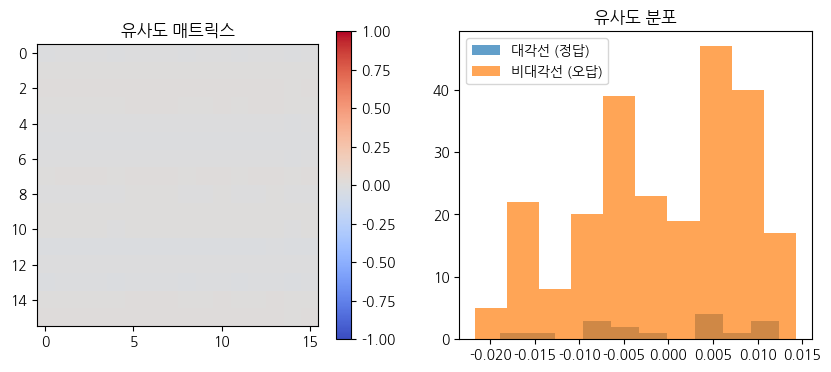


⚠️  InfoNCE 심각한 문제!


In [8]:
# InfoNCE 손실 함수 단독 테스트
print("🔗 InfoNCE 손실 함수 테스트...")

if 'text_embeddings' in locals() and 'vib_embeddings' in locals() and len(vib_embeddings) > 16:
    # 배치 크기만큼 샘플 선택
    batch_size = 16
    indices = np.random.choice(min(len(text_embeddings), len(vib_embeddings)), batch_size, replace=False)
    
    test_text_emb = torch.tensor(text_embeddings[indices], dtype=torch.float32)
    test_vib_emb = torch.tensor(vib_embeddings[indices], dtype=torch.float32)
    
    # InfoNCE 손실 함수 생성
    infonce_loss = InfoNCELoss(
        temperature_text=MODEL_CONFIG['infonce']['first_domain_temperature_text'],
        temperature_vib=MODEL_CONFIG['infonce']['first_domain_temperature_vib']
    )
    
    print(f"\n🔧 InfoNCE 설정:")
    print(f"   텍스트 온도: {infonce_loss.temperature_text}")
    print(f"   진동 온도: {infonce_loss.temperature_vib}")
    print(f"   배치 크기: {batch_size}")
    
    # 손실 계산
    try:
        total_loss, loss_components = infonce_loss(test_text_emb, test_vib_emb)
        
        print(f"\n📊 InfoNCE 손실 결과:")
        print(f"   총 손실: {total_loss.item():.4f}")
        print(f"   텍스트→진동: {loss_components['text_to_vib'].item():.4f}")
        print(f"   진동→텍스트: {loss_components['vib_to_text'].item():.4f}")
        
        # 유사도 매트릭스 분석
        text_norm = F.normalize(test_text_emb, dim=1)
        vib_norm = F.normalize(test_vib_emb, dim=1)
        similarity_matrix = torch.matmul(text_norm, vib_norm.t())
        
        print(f"\n🔍 유사도 매트릭스:")
        print(f"   대각선 평균: {torch.diag(similarity_matrix).mean().item():.4f}")
        print(f"   비대각선 평균: {(similarity_matrix.sum() - torch.diag(similarity_matrix).sum()).item() / (batch_size * (batch_size - 1)):.4f}")
        
        # Top-1 accuracy 계산
        top1_correct = (similarity_matrix.argmax(dim=1) == torch.arange(batch_size)).float().mean()
        print(f"   Top-1 정확도: {top1_correct.item():.4f} ({top1_correct.item()*100:.1f}%)")
        
        # 시각화
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.imshow(similarity_matrix.detach().numpy(), cmap='coolwarm', vmin=-1, vmax=1)
        plt.colorbar()
        plt.title('유사도 매트릭스')
        
        plt.subplot(1, 2, 2)
        diag_vals = torch.diag(similarity_matrix).detach().numpy()
        off_diag_vals = similarity_matrix.detach().numpy()
        off_diag_vals = off_diag_vals[~np.eye(off_diag_vals.shape[0], dtype=bool)]
        
        plt.hist(diag_vals, bins=10, alpha=0.7, label='대각선 (정답)')
        plt.hist(off_diag_vals, bins=10, alpha=0.7, label='비대각선 (오답)')
        plt.legend()
        plt.title('유사도 분포')
        plt.show()
        
        # 진단
        if top1_correct.item() < 0.1:
            print("\n⚠️  InfoNCE 심각한 문제!")
        elif top1_correct.item() < 0.3:
            print("\n⚠️  InfoNCE 성능 부족")
        else:
            print("\n✅ InfoNCE 정상 작동")
            
    except Exception as e:
        print(f"\n❌ InfoNCE 테스트 실패: {e}")
        
else:
    print("\n⚠️  충분한 유효 임베딩이 없어 InfoNCE 테스트 건너뜀")


## 📋 5단계: 종합 진단 및 권장사항


In [9]:
# 종합 진단 리포트
print("📋 TextVibCLIP 종합 진단 리포트")
print("=" * 50)

# 성능 요약
print(f"\n🎯 성능 요약:")
if 'text_accuracy' in locals():
    print(f"   텍스트 인코더: {text_accuracy:.3f} ({text_accuracy*100:.1f}%)")
else:
    print(f"   텍스트 인코더: 테스트 실패")
    
if 'vib_accuracy' in locals():
    print(f"   진동 인코더: {vib_accuracy:.3f} ({vib_accuracy*100:.1f}%)")
else:
    print(f"   진동 인코더: 테스트 실패")
    
if 'top1_correct' in locals():
    print(f"   InfoNCE Top-1: {top1_correct.item():.3f} ({top1_correct.item()*100:.1f}%)")
else:
    print(f"   InfoNCE: 테스트 실패")

# 문제 진단 및 권장사항
problems = []
recommendations = []

if 'text_accuracy' in locals() and text_accuracy < 0.6:
    problems.append("텍스트 인코더 성능 부족")
    recommendations.extend([
        "더 다양한 텍스트 설명 생성",
        "DistilBERT fine-tuning 강화"
    ])

if 'vib_accuracy' in locals() and vib_accuracy < 0.6:
    problems.append("진동 인코더 성능 부족")
    recommendations.extend([
        "TST → CNN+LSTM 아키텍처 변경",
        "진동 신호 전처리 개선"
    ])
elif 'nan_count' in locals() and (nan_count > 0 or inf_count > 0):
    problems.append("진동 인코더 수치적 불안정성")
    recommendations.extend([
        "Gradient clipping 추가",
        "학습률 감소"
    ])

if 'top1_correct' in locals() and top1_correct.item() < 0.3:
    problems.append("InfoNCE 정렬 실패")
    recommendations.extend([
        "온도 파라미터 재조정",
        "배치 크기 증가"
    ])

# 결과 출력
if problems:
    print(f"\n⚠️  발견된 문제점:")
    for i, problem in enumerate(problems, 1):
        print(f"   {i}. {problem}")
else:
    print(f"\n✅ 주요 문제점 없음")

if recommendations:
    print(f"\n🔧 권장사항:")
    for i, rec in enumerate(set(recommendations), 1):
        print(f"   {i}. {rec}")

# 우선순위 결정
print(f"\n🎯 개선 우선순위:")

vib_perf = vib_accuracy if 'vib_accuracy' in locals() else 0.0
text_perf = text_accuracy if 'text_accuracy' in locals() else 0.0

if vib_perf < text_perf:
    print("   1. 진동 인코더 개선 (가장 낮은 성능)")
    print("   2. 텍스트 인코더 개선")
    print("   3. InfoNCE 최적화")
else:
    print("   1. 텍스트 인코더 개선 (가장 낮은 성능)")
    print("   2. 진동 인코더 개선")
    print("   3. InfoNCE 최적화")

print(f"\n💡 결론:")
if len(problems) > 2:
    print("   - 다수의 문제점 발견, 단계별 개선 필요")
    print("   - 가장 성능이 낮은 컴포넌트부터 집중 개선")
elif len(problems) == 0:
    print("   - 개별 컴포넌트는 정상, 통합 과정 문제 가능성")
    print("   - 학습 파이프라인 점검 필요")
else:
    print("   - 특정 컴포넌트 문제 집중 해결 가능")

print("\n" + "=" * 50)
print("진단 완료! 위 결과를 바탕으로 개선 계획을 수립하세요.")


📋 TextVibCLIP 종합 진단 리포트

🎯 성능 요약:
   텍스트 인코더: 1.000 (100.0%)
   진동 인코더: 0.585 (58.5%)
   InfoNCE Top-1: 0.062 (6.2%)

⚠️  발견된 문제점:
   1. 진동 인코더 성능 부족
   2. InfoNCE 정렬 실패

🔧 권장사항:
   1. TST → CNN+LSTM 아키텍처 변경
   2. 진동 신호 전처리 개선
   3. 온도 파라미터 재조정
   4. 배치 크기 증가

🎯 개선 우선순위:
   1. 진동 인코더 개선 (가장 낮은 성능)
   2. 텍스트 인코더 개선
   3. InfoNCE 최적화

💡 결론:
   - 특정 컴포넌트 문제 집중 해결 가능

진단 완료! 위 결과를 바탕으로 개선 계획을 수립하세요.
